# Movie Recommendations

MovieLens is a research site run by GroupLens Research at the University of Minnesota. MovieLens (https://movielens.org/) shares with community several datasets containing user's ratings of some movies. 

Our goal is to build a recommender system that will recommend user some movies that he probably would like to see based on his already collected ratings of other movies. For the purposes of this exercise we will focus on using Collaborative Filtering as our approach.

![alt text](https://cdn.codecentric.de/20210310095830/Fig1-1.png)





# Libraries

In [1]:
# allows us to access dataframes
import pandas as pd

# specialized class for handling sparse matrices (compressed)
from scipy.sparse import csr_matrix

# Library for visualizing charts
import matplotlib.pylab as plt

# Fuzzy gives us access to functions that allow text scoring of similarities
from fuzzywuzzy import fuzz

# Gives us access to the unsupervised algorithm knn 
from sklearn.neighbors import NearestNeighbors

# Surprise is an easy-to-use Python scikit for recommender systems.
from surprise import SVD #SVD algorithm
from surprise import KNNBasic # Knn algorithm
from surprise import Dataset # Utility for loading datasets
from surprise import Reader # Allows surprise to interpret the ratings
from surprise.model_selection import cross_validate # cross validation utility


# Exploration

In [2]:
# https://grouplens.org/datasets/movielens
# https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

movies_df = pd.read_csv("data/ml-25m/movies.csv")
movies_df = movies_df.drop_duplicates() #remove duplicate rows
movies_df.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [3]:
movies_df.shape

(62423, 3)

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df = pd.read_csv("data/ml-25m/ratings.csv")
ratings_df = ratings_df.drop_duplicates() #remove duplicate rows
ratings_df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [6]:
ratings_df.shape

(25000095, 4)

In [7]:
#understand unique counts for the dataset

num_users = len(ratings_df.userId.unique())
num_items = len(ratings_df.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 162541 unique users and 59047 unique movies in this data set


In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Text(0.5, 1.0, 'Count of Movie Ratings per User Id')

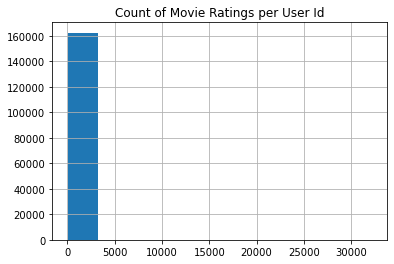

In [9]:
#How many ratings per User ID do we have?

ratings_df[['userId','movieId']].groupby(['userId']).count().hist()
plt.title("Count of Movie Ratings per User Id")


#most of the user have XX number of ratings

In [10]:
ratings_df[['userId','movieId']].groupby(['userId']).count().describe()

#there are 610 unique users
#what else can we say about the users?

,movieId
count,162541.000000
mean,153.807932
std,268.047590
min,20.000000
25%,36.000000
50%,71.000000
75%,162.000000
max,32202.000000


Text(0.5, 1.0, 'Count of User Ratings per Movie Id')

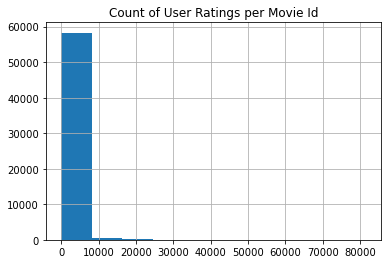

In [11]:
#How many user ratings per movie id do we have

ratings_df[['userId','movieId']].groupby(['movieId']).count().hist()
plt.title("Count of User Ratings per Movie Id")

In [12]:
ratings_df[['userId','movieId']].groupby(['movieId']).count().describe()

,userId
count,59047.000000
mean,423.393144
std,2477.885821
min,1.000000
25%,2.000000
50%,6.000000
75%,36.000000
max,81491.000000


In [13]:
# based on this we can identify a threshold for amount of ratings to use per user/movie 
# ie. what is a popular movie? an active user? 
# Feel free to make this more or less restrictive as your model requires

<AxesSubplot:title={'center':'Count of Rating Score'}>

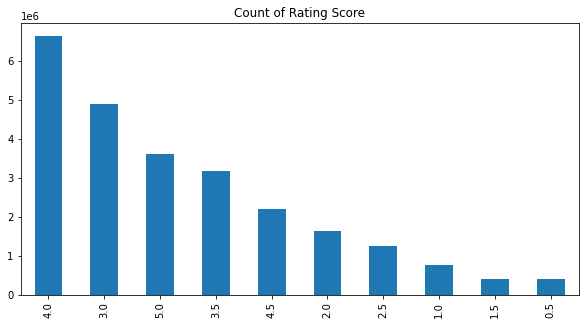

In [14]:
#look at ratings distribution

ratings_df['rating'].value_counts().plot.bar(title="Count of Rating Score",figsize=(10,5))

#what can we say about the ratings scores?

# Preprocessing

In [15]:
# Given some of our findings, let's try to optimize our dataset by filtering to only the data that we need

#why do we do this? #this is the minimum number of ratings per movie

popularity_thres = 20
movie_rating_cnt_df = ratings_df[['rating','movieId']].groupby(['movieId']).count()
popular_movies_df = movie_rating_cnt_df[movie_rating_cnt_df['rating']>=popularity_thres]


filtered_pop_movies_df = ratings_df[ratings_df.movieId.isin(popular_movies_df.index.values)]
print('shape of original ratings data: ', ratings_df.shape)
print('shape of ratings data after dropping unpopular movies: ', filtered_pop_movies_df.shape)

shape of original ratings data:  (25000095, 4)
shape of ratings data after dropping unpopular movies:  (24810483, 4)


In [16]:
#filtering for active users
ratings_thres = 20 
#max_thres= 100

active_users_cnt_df = ratings_df[['userId','movieId']].groupby(['userId']).count()
active_users_df = active_users_cnt_df[active_users_cnt_df['movieId']>=ratings_thres]

#active_users_df = active_users_cnt_df[(active_users_cnt_df['movieId']>=ratings_thres)& (active_users_cnt_df['movieId']< max_thres) ]

#display(active_users_df) 

filtered_popular_active_df = filtered_pop_movies_df[filtered_pop_movies_df.index.isin(active_users_df.index.values)]
print('shape of original ratings data: ', filtered_pop_movies_df.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', filtered_popular_active_df.shape)


shape of original ratings data:  (24810483, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (161468, 4)


In [17]:
filtered_popular_active_df.head()

,userId,movieId,rating,timestamp
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495


In [18]:
# Let's transform this into a movie-user pivot table
# Let's join them up first using a left join operation on movieId

filtered_movie_ratings_merged_df = pd.merge(filtered_popular_active_df,movies_df, how='left', on=['movieId'])
filtered_movie_ratings_merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
1,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
2,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
3,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance
4,1,1088,4.0,1147868495,Dirty Dancing (1987),Drama|Musical|Romance


In [19]:
# Now let's pivot the dataframe such that it will have movieId as the index, and userId as columns
filtered_movie_ratings_df = pd.pivot(filtered_movie_ratings_merged_df,index='movieId', columns='userId', values='rating').fillna(0)
filtered_movie_ratings_df.head()


userId,1,2,3,4,5,6,7,8,9,10,...,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,4.0,0.0,0.0,4.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.5,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#Matrices that contain mostly zero values are called sparse,
#distinct from matrices where most of the values are non-zero, called dense.

#It is computationally expensive to represent and work with sparse matrices as though they are dense, 
#and much improvement in performance can be achieved by using representations and operations 
#that specifically handle the matrix sparsity.

#Instead of storing zeroes with non-zero elements, we only store non-zero elements. 
#This means storing non-zero elements with triples- (Row, Column, value).

# Now given that this is a sparse matrix, we will use scipy which has a matrix class
# that is optimized to handle sparse matrix objects

#The function csr_matrix() is used to create a sparse matrix of compressed sparse row format 
#whereas csc_matrix() is used to create a sparse matrix of compressed sparse column format.



movie_ratings_mat = csr_matrix(filtered_popular_active_df.values)
movie_ratings_mat

# this will be used as input to the model

<161468x4 sparse matrix of type '<class 'numpy.float64'>'
	with 645872 stored elements in Compressed Sparse Row format>

# Memory-based Approach
## Using KNN to estimate distance

Here we will use KNN, which is an unsupervised learning model, in which a data point is classified by a majority vote of its neighbors, with the data point being assigned to the class most common amongst its k-nearest neighbors, as measured by a distance function (these can be of any kind depending upon your data being continuous or categorical). If k = 1, then the data point is simply assigned to the class of its nearest neighbor—i.e., itself.

In [21]:
# Metric is the distance algorithm to be used. You can find more choices here: 
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric

# algorithm is the type of tree search used by the model
# neighbors it the amount of neighbors identified
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit
model_knn.fit(movie_ratings_mat)


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

KNN does not make any assumptions on the underlying data distribution but it relies on item feature similarity. When KNN makes inference about a movie, KNN will calculate the “distance” between the target movie and every other movie in its database, then it ranks its distances and returns the top K nearest neighbor movies as the most similar movie recommendations.

![alt text](https://miro.medium.com/max/975/1*OyYyr9qY-w8RkaRh2TKo0w.png)

In [22]:
# Let's try it out
fav_movie = "GoldenEye"
print('You have input movie:', fav_movie)

# find movies that "match" title
movie_matches_df = filtered_movie_ratings_merged_df[filtered_movie_ratings_merged_df['title'].str.contains(fav_movie)]  
movie_matches_df=movie_matches_df[['movieId','title']].drop_duplicates()
movie_matches_df


You have input movie: GoldenEye


,movieId,title
1277,10,GoldenEye (1995)


# Let's Recommend!

In [23]:
print("Let's start making recommendations!...")

if(movie_matches_df is  None):
    print("No Matching movies :(")
else:
    # Indicate the top recommendations we want to get (how many neighbors should we find?)
    top_recommendations = 10

    movie_idx= movie_matches_df.iloc[0]['movieId'] # select the first movie in the list, get the movie Id
    
    # get the dataframe index from the movieId
    movie_idx = filtered_movie_ratings_merged_df[filtered_movie_ratings_merged_df['movieId'] == movie_idx].index[0]

    # model will return a list of distances and indices
    distances , indices = model_knn.kneighbors(movie_ratings_mat[movie_idx],n_neighbors=top_recommendations+1)    

    # transform the result into a list
    rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    recommend_frame = [] #let's create an empty list
 
    # we will iterate thru the results and add them to the list
    for val in rec_movie_indices:
        
        # we get the movie id
        movie_idx = filtered_movie_ratings_merged_df.iloc[val[0]]['movieId']
        # convert into an index, we will this use to get the movie title
        idx = filtered_movie_ratings_merged_df[filtered_movie_ratings_merged_df['movieId'] == movie_idx].index
        # take the movie title together with the computed "distance". This distance is how far the movies are from the 'target' movie
        recommend_frame.append({'Title':filtered_movie_ratings_merged_df.iloc[idx]['title'].values[0],'Distance':val[1]})

    # place resulting list inside a dataframe
    df = pd.DataFrame(recommend_frame,index=range(1,top_recommendations+1))
    display(df.sort_values("Distance")) #sort by distance to get the top 10


Let's start making recommendations!...


,Title,Distance
1,Toy Story (1995),0.0
2,Sense and Sensibility (1995),0.0
3,GoldenEye (1995),0.0
4,Mortal Kombat (1995),0.0
5,Casino (1995),0.0
6,Grumpier Old Men (1995),0.0
7,Heat (1995),0.0
8,Sabrina (1995),0.0
9,"American President, The (1995)",0.0
10,Jumanji (1995),0.0


In [24]:
# Let's use surprise library to get a measure of our knn model's RMSE metric
# The Reader class is used to parse a file containing ratings.
# A reader is still needed but only the rating_scale param is required.

reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_movie_ratings_merged_df[['userId', 'movieId', 'rating']], reader)

# We'll train a knn model in surprise using our same data set
knnbasic = KNNBasic()

# Run 5-fold cross-validation and print results.
knn_results = cross_validate(knnbasic, data, measures=['RMSE'], cv=5, verbose=True)
knn_results


# Smaller RMSE means our model is able to give better recommendation

#how do we try other knn models?

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9402  0.9401  0.9338  0.9423  0.9426  0.9398  0.0032  
Fit time          0.20    0.19    0.19    0.21    0.19    0.20    0.01    
Test time         2.25    2.18    2.17    2.19    2.23    2.20    0.03    


{'test_rmse': array([0.94016613, 0.94007711, 0.93381825, 0.94233696, 0.94257967]),
 'fit_time': (0.20105600357055664,
  0.1911311149597168,
  0.18802380561828613,
  0.21254968643188477,
  0.1878831386566162),
 'test_time': (2.2538790702819824,
  2.1752519607543945,
  2.167039155960083,
  2.187563896179199,
  2.23061203956604)}

# Model based approach

To Make things much more easier, we will be using the Surprise scikit which specializes in recommender models.

Continuing our Collaborative Filtering example, we will now use a model based approach via SVD (Singular Value Decomposition), as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization [salakhutdinov2008a].

Supplementary reading for SVD: https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d

SVD vs PCA https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491

"From a simplified perspective, PCA transforms data linearly into new properties that are not correlated with each other. For ML, positioning PCA as feature extraction may allow us to explore its potential better than dimension reduction.
What is the difference between SVD and PCA? SVD gives you the whole nine-yard of diagonalizing a matrix into special matrices that are easy to manipulate and to analyze. It lay down the foundation to untangle data into independent components. PCA skips less significant components. Obviously, we can use SVD to find PCA by truncating the less important basis vectors in the original SVD matrix"

In [25]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_movie_ratings_merged_df[['userId', 'movieId', 'rating']], reader)

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results.
svd_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
svd_results

# Smaller RMSE means our model is able to give better recommendation

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8680  0.8713  0.8663  0.8671  0.8687  0.8683  0.0017  
Fit time          6.12    6.05    6.18    5.94    6.08    6.07    0.08    
Test time         0.19    0.19    0.19    0.13    0.13    0.17    0.03    


{'test_rmse': array([0.8679762 , 0.87132172, 0.86629547, 0.86714643, 0.86873927]),
 'fit_time': (6.121275901794434,
  6.050466775894165,
  6.1817920207977295,
  5.939718961715698,
  6.0791332721710205),
 'test_time': (0.19131803512573242,
  0.1883530616760254,
  0.19137287139892578,
  0.13079190254211426,
  0.1300969123840332)}

# Let's try to predict

In [26]:
# User rated 4
uid = str(1)  

# Movie: Grumpier Old Men (1995)
iid = str(3)  

#Get the prediction for the specific users and movie.
print("Prediction for rating: ")
pred = algo.predict(uid, iid, r_ui=4, verbose=True)
pred

Prediction for rating: 
user: 1          item: 3          r_ui = 4.00   est = 3.57   {'was_impossible': False}


Prediction(uid='1', iid='3', r_ui=4, est=3.5732107605960906, details={'was_impossible': False})

In [27]:
# Our model was able to predict that the user (1) will rate the movie (3) a score of 3.855 (4)

# Let's compare the two using RMSE

In [28]:
metric_df = pd.DataFrame()
metric_df['knn'] = knn_results['test_rmse']
metric_df['svd'] = svd_results['test_rmse']

tmp_dict1 = {'knn':metric_df['knn'].mean(),'svd':metric_df['svd'].mean()}
tmp_dict2 = {'knn':metric_df['knn'].std(),'svd':metric_df['svd'].std()}

metric_df = metric_df.append(tmp_dict1,ignore_index=True)
metric_df = metric_df.append(tmp_dict2,ignore_index=True)
metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std']
metric_df


,knn,svd
Fold 1,0.940166,0.867976
Fold 2,0.940077,0.871322
Fold 3,0.933818,0.866295
Fold 4,0.942337,0.867146
Fold 5,0.942580,0.868739
Mean,0.939796,0.868296
Std,0.003541,0.001922


# Top n predictions and the hit rate

We want to be able to generate the top N predictions using the two models and calculate hit rate.

After generating top n, if one recommendation they actually rated, you consider it a hit.

In [29]:
from collections import defaultdict

# accept list of predictions and n of top n
#this is like our scoring algorithm for reco engines

def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        # top_n = is a dictionary to map rating to a userid as key
        # est = predicted rating
        # iid = movie id
        # uid = user id
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        
        # x[1] refers to the est score, which means sort highest to lowest using the rating per user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [30]:
#to illustrate how to compute for hit rate, we will use the Leave One Out dataset

from surprise.model_selection import LeaveOneOut

# Let's rebuild our models
# A reader is still needed but only the rating_scale param is required.
# this indicates our rating is 1 to 5 only

reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_movie_ratings_merged_df[['userId', 'movieId', 'rating']], reader)

#Build a "leave one out" train/test split for evaluating top-N recommenders
LOOCV = LeaveOneOut(n_splits=1, random_state=1)
for train, test in LOOCV.split(data):
    LOOCVTrain = train
    LOOCVTest = test

#Save leave one out test predictions
leftoutpredictions = LOOCVTest


#And build an anti-test-set for building predictions
LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()


# generate two models
knn = KNNBasic()
svd = SVD()

# fit using generated training set from data
knn.fit(LOOCVTrain)
svd.fit(LOOCVTrain)

# Then predict ratings for all pairs (u, i) that are NOT in the training set (from data)
#testset = trainset.build_anti_testset()

# generate predictions
knn_predictions = knn.test(LOOCVAntiTestSet)
svd_predictions = svd.test(LOOCVAntiTestSet)



Computing the msd similarity matrix...
Done computing similarity matrix.


In [31]:
# generate top ten recommendations based on users NOT in the training set
knn_top_n = get_top_n(knn_predictions, n=10)
svd_top_n = get_top_n(svd_predictions, n=10)

# Print the recommended items for each user
print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

print("")
print("top n recommendations for svd")   
for uid, user_ratings in svd_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


top n recommendations for knn
1 [113, 30867, 33270, 109364, 141432, 1604, 135532, 984, 33893, 143009]
2 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
3 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 104728, 8190]
4 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 104728, 8190]
5 [5912, 7938, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869]
6 [5912, 7938, 30867, 33270, 109364, 141432, 33893, 143009, 105869, 116855]
7 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
8 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
9 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
10 [5912, 7938, 30867, 33270, 109364, 141432, 33893, 143009, 105869, 116855]
11 [5912, 7938, 30867, 33270, 109364, 141432, 135532, 984, 33893, 143009]
12 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
13 [2632, 30867, 33270, 109364, 141432, 135532, 338

1010 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
1011 [2632, 33893, 143009, 105869, 116855, 104728, 8190, 8617, 32124, 1169]
1012 [2632, 30867, 33270, 109364, 141432, 33893, 143009, 105869, 116855, 104728]
1013 [2632, 30867, 33270, 109364, 141432, 33893, 143009, 105869, 116855, 104728]
1014 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
1015 [5912, 7938, 30867, 33270, 109364, 141432, 50851, 135532, 33893, 143009]
1016 [5912, 7938, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869]
1017 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
1018 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
1019 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
1020 [2632, 30867, 33270, 109364, 141432, 135532, 33893, 143009, 105869, 116855]
1021 [2632, 30867, 33270, 109364, 141432, 33893, 143009, 105869, 116855, 104728]
1022 [5912, 7938, 30867, 33270, 109364

555 [1243, 318, 858, 2858, 159817, 128360, 4993, 115713, 527, 7153]
556 [6016, 858, 1193, 7099, 128360, 1809, 159817, 1207, 3504, 117533]
557 [318, 1217, 7099, 1204, 1221, 2329, 933, 1234, 3508, 858]
558 [1201, 1957, 1148, 1213, 1221, 159817, 171011, 1243, 3000, 1809]
559 [1217, 1147, 2762, 1221, 3435, 96829, 1237, 307, 1293, 318]
560 [2329, 1217, 3000, 142488, 527, 7099, 1221, 2944, 1147, 4239]
561 [6016, 858, 7153, 4011, 27773, 159817, 1266, 2288, 2076, 4848]
562 [3134, 7099, 4144, 1209, 1217, 1281, 307, 904, 1674, 4993]
563 [2324, 1221, 1217, 1809, 2692, 2959, 1178, 1193, 2360, 858]
564 [318, 1237, 1197, 858, 159817, 2324, 1293, 27773, 3134, 7099]
565 [2692, 318, 48394, 1732, 50, 3996, 4973, 4993, 3508, 5952]
566 [3134, 58559, 6987, 1147, 89745, 27846, 7099, 3000, 2959, 3468]
567 [1196, 159817, 94959, 85342, 1293, 1217, 3000, 1201, 1358, 8638]
568 [1221, 1217, 50, 1213, 2019, 1961, 2324, 1237, 1704, 1296]
569 [4226, 1217, 1243, 1221, 527, 26776, 50, 318, 5291, 1147]
570 [527, 1147, 

In [32]:
# utility function to get the movie title based on the movieId
def get_title_from_id(idx):
    return filtered_movie_ratings_merged_df[filtered_movie_ratings_merged_df['movieId']==idx]['title'].values[0]

In [33]:
# Print the recommended items for each user
print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])

print("")
print("top n recommendations for svd")   
for uid, user_ratings in svd_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])


top n recommendations for knn
1 ['Before and After (1996)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Money Talks (1997)', 'The Last Witch Hunter (2015)', 'Pompatus of Love, The (1996)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)']
2 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
3 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and

24 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
25 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
26 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the 

68 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
69 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
70 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (

90 ['Hit the Bank (Vabank) (1981)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Life is a Miracle (Zivot je cudo) (2004)', 'Zach Galifianakis: Live at the Purple Onion (2006)', 'Pure (2009)', 'Kill Your Darlings (2013)']
91 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
92 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingb

112 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
113 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
114 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji

134 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
135 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
136 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha n

161 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
162 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
163 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha n

183 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
184 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Pompatus of Love, The (1996)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
185 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King 

210 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
211 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
212 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King 

234 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
235 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
236 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha n

262 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
263 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Pompatus of Love, The (1996)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)']
264 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The

286 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Horseman on the Roof, The (Hussard sur le toit, Le) (1995)', 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 'Mephisto (1981)', 'The Last Witch Hunter (2015)']
287 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
288 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, Th

314 ['Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
315 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
316 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi

337 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
338 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', 'Redline (2009)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
339 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)'

360 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
361 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Your Friends and Neighbors (1998)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
362 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "

382 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
383 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', 'Redline (2009)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Lymelife (2008)']
384 ['Hit the Bank (Vabank) (1981)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (198

409 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
410 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'One Direction: This Is Us (2013)', 'Americanization of Emily, The (1964)']
411 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of 

433 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Cocaine Cowboys (2006)', 'The Last Witch Hunter (2015)', 'Life is a Miracle (Zivot je cudo) (2004)', 'Zach Galifianakis: Live at the Purple Onion (2006)']
434 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
435 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mo

461 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
462 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
463 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Your Friends and Neighbors (1998)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of 

485 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Anne Frank Remembered (1995)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', 'Redline (2009)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Ball of Fire (1941)', 'Cocaine Cowboys (2006)']
486 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
487 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Anne Frank Remembered (1995)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the 

514 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
515 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
516 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha n

537 ['Hit the Bank (Vabank) (1981)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
538 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
539 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingb

566 ['Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)', 'One Direction: This Is Us (2013)']
567 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
568 ['Hit the Bank (Vabank) (1981)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 

589 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
590 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
591 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji

618 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
619 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)', 'One Direction: This Is Us (2013)']
620 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (C

641 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
642 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
643 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha n

670 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
671 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
672 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mo

693 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
694 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
695 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mocking

722 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
723 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
724 ['Hit the Bank (Vabank) (1981)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, 

746 ['Hit the Bank (Vabank) (1981)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)', 'One Direction: This Is Us (2013)']
747 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
748 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbi

773 ['Hit the Bank (Vabank) (1981)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
774 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Love Affair (1994)', 'Horseman on the Roof, The (Hussard sur le toit, Le) (1995)', 'Money Talks (1997)', 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)']
775 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird,

796 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Godzilla 1985: The Legend Is Reborn (Gojira) (Godzilla) (Return of Godzilla, The) (1984)', 'One Direction: This Is Us (2013)']
797 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
798 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monoga

825 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Pompatus of Love, The (1996)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
826 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)', 'One Direction: This Is Us (2013)']
827 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (C

846 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)', 'One Direction: This Is Us (2013)']
847 ['Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)', 'One Direction: This Is Us (2013)']
848 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "K

873 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', 'Redline (2009)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
874 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
875 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockin

895 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
896 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)', 'One Direction: This Is Us (2013)']
897 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King a

925 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
926 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
927 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and t

948 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
949 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
950 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King 

977 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
978 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
979 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and t

1000 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
1001 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
1002 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Ch

1027 ['Hit the Bank (Vabank) (1981)', 'Winter Light (Nattvardsgästerna) (1963)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', 'Redline (2009)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Cocaine Cowboys (2006)', 'The Last Witch Hunter (2015)', 'Life is a Miracle (Zivot je cudo) (2004)']
1028 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
1029 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Your Friends and Neighbors (1998)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji)

1051 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
1052 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)', 'One Direction: This Is Us (2013)']
1053 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha

1073 ['Hit the Bank (Vabank) (1981)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
1074 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
1075 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbir

1116 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Pompatus of Love, The (1996)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)']
1117 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Cha no aji) (2004)', "King and the Mockingbird, The (Le roi et l'oiseau) (1980)", 'Sweet Red Bean Paste (2015)', 'The Last Witch Hunter (2015)', 'Perfect Crime, The (Crimen Ferpecto) (Ferpect Crime) (2004)', 'Pure (2009)', 'Kill Your Darlings (2013)', 'The Way He Looks (2014)']
1118 ['Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)', 'Kamikaze Girls (Shimotsuma monogatari) (2004)', 'Taste of Tea, The (Ch

7 ['Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Hustler, The (1961)', 'Lord of the Rings: The Two Towers, The (2002)', 'Gandhi (1982)', 'North by Northwest (1959)', 'Godfather, The (1972)', 'Shawshank Redemption, The (1994)', 'Citizenfour (2014)', 'Blade Runner (1982)', 'Outlaw Josey Wales, The (1976)']
8 ['Godfather: Part II, The (1974)', 'Man on Fire (2004)', 'Gone Girl (2014)', 'Spotlight (2015)', 'Happiness (1998)', 'Graduate, The (1967)', 'Ran (1985)', 'Ordinary People (1980)', 'Whiplash (2013)', 'Science of Sleep, The (La science des rêves) (2006)']
9 ['Wallace & Gromit: The Best of Aardman Animation (1996)', 'All About My Mother (Todo sobre mi madre) (1999)', 'Remember the Titans (2000)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Lady Eve, The (1941)', 'Ex Machina (2015)', 'Outlaw Josey Wales, The (1976)', 'Game, The (1997)', 'Replacement Killers, The (1998)', 'Planet Earth (2006)']
10 ['Monty Python and the Holy Grail (

56 ['Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Rosencrantz and Guildenstern Are Dead (1990)', 'Ran (1985)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Shawshank Redemption, The (1994)', 'Waltz with Bashir (Vals im Bashir) (2008)', 'Godfather: Part II, The (1974)', 'Seven (a.k.a. Se7en) (1995)', 'Godfather, The (1972)', 'Wallace & Gromit: The Best of Aardman Animation (1996)']
57 ['Seven Samurai (Shichinin no samurai) (1954)', 'Blade Runner (1982)', "One Flew Over the Cuckoo's Nest (1975)", 'Godfather: Part II, The (1974)', 'Godfather, The (1972)', 'Goodfellas (1990)', 'Lawrence of Arabia (1962)', 'Apocalypse Now (1979)', 'Maltese Falcon, The (1941)', 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)']
58 ['Ran (1985)', 'Shawshank Redemption, The (1994)', 'Godfather, The (1972)', 'Godfather: Part II, The (1974)', 'Rear Window (1954)', 'Citizen Kane (1941)', 'Grand Illusion (La grande illusion) (1937)', 'All About My Mother (Todo s

107 ['Ran (1985)', 'Usual Suspects, The (1995)', 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)', 'Grand Illusion (La grande illusion) (1937)', 'Godfather: Part II, The (1974)', 'My Neighbor Totoro (Tonari no Totoro) (1988)', 'Magnificent Seven, The (1960)', 'Planet Earth II (2016)', 'Old Boy (2003)', 'Maltese Falcon, The (1941)']
108 ['Godfather: Part II, The (1974)', 'Godfather, The (1972)', 'Goodfellas (1990)', 'Planet Earth (2006)', 'Outlaw Josey Wales, The (1976)', 'Paths of Glory (1957)', 'Sling Blade (1996)', 'Casablanca (1942)', '12 Angry Men (1957)', 'Blade Runner (1982)']
109 ['Planet Earth (2006)', 'Rosencrantz and Guildenstern Are Dead (1990)', 'Outlaw Josey Wales, The (1976)', 'King and I, The (1956)', 'Waltz with Bashir (Vals im Bashir) (2008)', 'Elite Squad: The Enemy Within (Tropa de Elite 2 - O Inimigo Agora É Outro) (2010)', 'Spotlight (2015)', 'Citizenfour (2014)', 'The Martian (2015)', 'Fireworks (Hana-bi) (1997)']
110 ['Wallace & Gromit: The Best of Aardman An

158 ['Godfather, The (1972)', '2001: A Space Odyssey (1968)', 'Godfather: Part II, The (1974)', 'Citizen Kane (1941)', 'Seven Samurai (Shichinin no samurai) (1954)', 'Blade Runner (1982)', 'Old Boy (2003)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Ran (1985)', 'Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)']
159 ['Princess Mononoke (Mononoke-hime) (1997)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Celebration, The (Festen) (1998)', 'Fireworks (Hana-bi) (1997)', 'Planet Earth II (2016)', 'Double Indemnity (1944)', 'Spartacus (1960)', 'Snatch (2000)', 'Ran (1985)', 'Henry V (1989)']
160 ['Star Wars: Episode IV - A New Hope (1977)', "One Flew Over the Cuckoo's Nest (1975)", 'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)', 'Usual Suspects, The (1995)', 'Citizen Kane (1941)', 'Godfather, The (1972)', "Singin' in the Rain (1952)", 'Die Hard (1988)', 'Raiders of the Lost Ark (Indiana J

206 ['Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)', 'Life Is Beautiful (La Vita è bella) (1997)', 'Grand Illusion (La grande illusion) (1937)', 'Raging Bull (1980)', 'Fight Club (1999)', 'Rear Window (1954)', "Singin' in the Rain (1952)", 'Memento (2000)', 'Reservoir Dogs (1992)', 'City of God (Cidade de Deus) (2002)']
207 ['Amadeus (1984)', 'Godfather: Part II, The (1974)', 'Sling Blade (1996)', 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)', 'Office Space (1999)', 'Incendies (2010)', 'Three Colors: Blue (Trois couleurs: Bleu) (1993)', 'Magnificent Seven, The (1960)', 'Usual Suspects, The (1995)', 'Wallace & Gromit: The Best of Aardman Animation (1996)']
208 ['Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Blade Runner (1982)', 'Spartacus (1960)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Celebration, The (Festen) (1998)', 'Gandhi (1982)', "Amores Perros (Love's a Bitch) (2000)", 'Apocalypse Now (1979)', 'Seventh Seal, The (Sjunde inseglet, Det

252 ['City of God (Cidade de Deus) (2002)', 'Seven Samurai (Shichinin no samurai) (1954)', 'Lawrence of Arabia (1962)', 'Silence of the Lambs, The (1991)', 'Memento (2000)', 'Ran (1985)', 'Seventh Seal, The (Sjunde inseglet, Det) (1957)', "One Flew Over the Cuckoo's Nest (1975)", 'Usual Suspects, The (1995)', 'Godfather, The (1972)']
253 ['Godfather, The (1972)', 'Ran (1985)', 'Grand Illusion (La grande illusion) (1937)', 'Godfather: Part II, The (1974)', 'Fight Club (1999)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Rosencrantz and Guildenstern Are Dead (1990)', 'My Neighbor Totoro (Tonari no Totoro) (1988)', 'Seven Samurai (Shichinin no samurai) (1954)', 'Sling Blade (1996)']
254 ['The Martian (2015)', 'Game, The (1997)', '25th Hour (2002)', 'Mulholland Drive (2001)', 'Triplets of Belleville, The (Les triplettes de Belleville) (2003)', 'Taste of Others, The (Le goût des autres) (2000)', 'My Life as a Dog (Mitt liv som hund) (1985)', 'Citizenfour (2014)'

301 ["Once Upon a Time in the West (C'era una volta il West) (1968)", 'Seven Samurai (Shichinin no samurai) (1954)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986)', 'Old Boy (2003)', 'Metropolis (1927)', 'Outlaw Josey Wales, The (1976)', 'Sting, The (1973)', 'Celebration, The (Festen) (1998)', 'Ran (1985)']
302 ['25th Hour (2002)', 'Rosencrantz and Guildenstern Are Dead (1990)', 'Office Space (1999)', 'My Neighbor Totoro (Tonari no Totoro) (1988)', 'Pale Rider (1985)', 'Paths of Glory (1957)', 'Local Hero (1983)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Three Colors: Blue (Trois couleurs: Bleu) (1993)', 'When We Were Kings (1996)']
303 ['American Beauty (1999)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'My Fair Lady (1964)', 'Paths of Glory (1957)', 'Citizenfour (2014)', "Schindler's List (1993)", 'Casablanca (1942)', 'Rashomon (Rashômon) (1950)', 'Ran 

351 ['Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Shawshank Redemption, The (1994)', 'Godfather, The (1972)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Planet Earth (2006)', 'Godfather: Part II, The (1974)', 'American History X (1998)', 'Ran (1985)', 'Paths of Glory (1957)', 'Roman Holiday (1953)']
352 ['Shawshank Redemption, The (1994)', 'Grand Illusion (La grande illusion) (1937)', "Once Upon a Time in the West (C'era una volta il West) (1968)", 'Blade Runner (1982)', 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)', 'Fight Club (1999)', 'Inception (2010)', "Schindler's List (1993)", 'Godfather, The (1972)', 'Trainspotting (1996)']
353 ['Wallace & Gromit: The Best of Aardman Animation (1996)', 'Ran (1985)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)', 'Godfather: Part II, The (1974)', 'Nausicaä of the Valley of the Wind (Kaze no tani no N

401 ['Ran (1985)', 'Patton (1970)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Mister Roberts (1955)', 'Planet Earth (2006)', 'Seven Samurai (Shichinin no samurai) (1954)', 'Godfather: Part II, The (1974)', 'Henry V (1989)', 'All About My Mother (Todo sobre mi madre) (1999)', 'Double Indemnity (1944)']
402 ['Grand Illusion (La grande illusion) (1937)', 'Usual Suspects, The (1995)', 'Citizenfour (2014)', "All the President's Men (1976)", 'Fireworks (Hana-bi) (1997)', 'Eddie Murphy Raw (1987)', 'Great Dictator, The (1940)', 'Fight Club (1999)', 'Lawrence of Arabia (1962)', 'All About My Mother (Todo sobre mi madre) (1999)']
403 ['Old Boy (2003)', 'Sling Blade (1996)', 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', "Schindler's List (1993)", "Once Upon a Time in the West (C'era una volta il West) (1968)", 'Seven Samurai (Shichinin no samurai) (1954)', 'Good, the Bad and the Ugly, The (

451 ['Ran (1985)', 'Shawshank Redemption, The (1994)', "Schindler's List (1993)", '12 Angry Men (1957)', 'When We Were Kings (1996)', 'Grand Illusion (La grande illusion) (1937)', 'Lone Star (1996)', 'Creature Comforts (1989)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Fireworks (Hana-bi) (1997)']
452 ['Ran (1985)', 'City of God (Cidade de Deus) (2002)', 'Godfather: Part II, The (1974)', 'Seven Samurai (Shichinin no samurai) (1954)', 'Planet Earth (2006)', 'My Life as a Dog (Mitt liv som hund) (1985)', 'Player, The (1992)', 'Inception (2010)', 'Bridge on the River Kwai, The (1957)', 'Usual Suspects, The (1995)']
453 ['Fight Club (1999)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Matrix, The (1999)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Alien (1979)', 'American History X (1998)', 'Planet Earth (2006)', 'Seven (a.k.a. Se7en) (1995)', 'Usual Suspects, The (1995)', 'Magnificent Seven, The (1960)']
454 ['Casablanca (1942)', 'Usual Suspects, The (199

501 ['Pulp Fiction (1994)', 'Ran (1985)', 'City of God (Cidade de Deus) (2002)', 'Before Sunrise (1995)', 'Planet Earth (2006)', 'Your Name. (2016)', 'Django Unchained (2012)', 'Inception (2010)', 'Grand Day Out with Wallace and Gromit, A (1989)', 'Wallace & Gromit: The Wrong Trousers (1993)']
502 ["Schindler's List (1993)", 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Old Boy (2003)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Hunt, The (Jagten) (2012)', 'Grand Illusion (La grande illusion) (1937)', 'Talk to Her (Hable con Ella) (2002)', 'Celebration, The (Festen) (1998)', 'In the Mood For Love (Fa yeung nin wa) (2000)', 'Braveheart (1995)']
503 ['Ran (1985)', 'Seventh Seal, The (Sjunde inseglet, Det) (1957)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Outlaw Josey Wales, The (1976)', 'City of God (Cidade de Deus) (2002)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', '12 Angry Men (1957)', 'Gandhi (1982)', 'Hunt,

551 ['Henry V (1989)', 'Princess Bride, The (1987)', 'Science of Sleep, The (La science des rêves) (2006)', "Kiki's Delivery Service (Majo no takkyûbin) (1989)", 'Fight Club (1999)', 'Godfather, The (1972)', 'Double Indemnity (1944)', 'Inception (2010)', 'Great Escape, The (1963)', 'Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986)']
552 ['Godfather: Part II, The (1974)', 'No Country for Old Men (2007)', 'Apocalypse Now (1979)', 'Whiplash (2013)', 'Blade Runner (1982)', 'Spotlight (2015)', 'Terminator 2: Judgment Day (1991)', 'Rashomon (Rashômon) (1950)', 'Shining, The (1980)', 'Django Unchained (2012)']
553 ['Shawshank Redemption, The (1994)', 'Grave of the Fireflies (Hotaru no haka) (1988)', 'Seventh Seal, The (Sjunde inseglet, Det) (1957)', 'Planet Earth (2006)', 'Usual Suspects, The (1995)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Godfather, The (1972)', 'Fireworks (Hana-bi) (1997)', 'Monty Python and the Holy Grail (1975)', 'Arrival (2016)'

601 ['Planet Earth II (2016)', 'Shawshank Redemption, The (1994)', 'Seventh Seal, The (Sjunde inseglet, Det) (1957)', 'Scarface (1983)', 'Three Colors: Blue (Trois couleurs: Bleu) (1993)', 'When We Were Kings (1996)', 'Game, The (1997)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'My Neighbor Totoro (Tonari no Totoro) (1988)', "Schindler's List (1993)"]
602 ['Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)', 'Blade Runner (1982)', 'Planet Earth (2006)', 'Gandhi (1982)', 'Paths of Glory (1957)', 'North by Northwest (1959)', 'Third Man, The (1949)', 'Old Boy (2003)', 'Lawrence of Arabia (1962)', 'Sling Blade (1996)']
603 ['Gandhi (1982)', 'Life Is Beautiful (La Vita è bella) (1997)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Great Escape, The (1963)', 'Princess Bride, The (1987)', 'Wallace & Gromit: The Wrong Trousers (1993)', 'When We Were Kings (1996)', 'Great Dictator, The (1940)', 'Rosencrantz and Guildenstern Are Dead (1990)', "Once U

650 ['Pulp Fiction (1994)', 'Godfather, The (1972)', 'Hustler, The (1961)', 'Outlaw Josey Wales, The (1976)', 'Godfather: Part II, The (1974)', 'American Beauty (1999)', "Schindler's List (1993)", 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)', 'When We Were Kings (1996)', 'Seventh Seal, The (Sjunde inseglet, Det) (1957)']
651 ['Silence of the Lambs, The (1991)', 'Ran (1985)', 'Memento (2000)', "One Flew Over the Cuckoo's Nest (1975)", 'Shawshank Redemption, The (1994)', 'Usual Suspects, The (1995)', 'Blade Runner (1982)', 'Citizenfour (2014)', 'Seven Samurai (Shichinin no samurai) (1954)', 'To Kill a Mockingbird (1962)']
652 ['Ran (1985)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', "Amores Perros (Love's a Bitch) (2000)", 'Rear Window (1954)', 'Matrix, The (1999)', 'Incendies (2010)', "Monty Python's And Now for Something Completely Different (1971)", 'Rosencrantz and Guildenstern Are Dead (1990)', 'Star Wars: Episode IV - A Ne

699 ["Schindler's List (1993)", 'North by Northwest (1959)', 'Godfather, The (1972)', 'Citizen Kane (1941)', 'Usual Suspects, The (1995)', 'Star Wars: Episode IV - A New Hope (1977)', 'Godfather: Part II, The (1974)', 'My Neighbor Totoro (Tonari no Totoro) (1988)', 'Silence of the Lambs, The (1991)', 'Ben-Hur (1959)']
700 ['Memento (2000)', 'Planet Earth (2006)', 'Double Indemnity (1944)', 'Life Is Beautiful (La Vita è bella) (1997)', 'Grand Illusion (La grande illusion) (1937)', 'Sound of Music, The (1965)', 'Shawshank Redemption, The (1994)', 'Chariots of Fire (1981)', "Monty Python's And Now for Something Completely Different (1971)", 'Gandhi (1982)']
701 ['Shawshank Redemption, The (1994)', 'Planet Earth (2006)', 'Fireworks (Hana-bi) (1997)', 'Sound of Music, The (1965)', 'Elite Squad: The Enemy Within (Tropa de Elite 2 - O Inimigo Agora É Outro) (2010)', 'King and I, The (1956)', 'Goodfellas (1990)', 'Gandhi (1982)', 'Braveheart (1995)', 'To Kill a Mockingbird (1962)']
702 ['Ran (

749 ['Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'American History X (1998)', 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)', 'Creature Comforts (1989)', 'Amadeus (1984)', 'Grave of the Fireflies (Hotaru no haka) (1988)', 'Psycho (1960)', 'My Neighbor Totoro (Tonari no Totoro) (1988)', 'Lawrence of Arabia (1962)', 'Princess Mononoke (Mononoke-hime) (1997)']
750 ['Pulp Fiction (1994)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Fight Club (1999)', 'Gandhi (1982)', 'Amadeus (1984)', 'Blade Runner (1982)', 'Rashomon (Rashômon) (1950)']
751 ['Blade Runner (1982)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)', 'City of God (Cidade de Deus) (2002)', 'Planet Earth (2006)', 'Godfather,

799 ['Princess Mononoke (Mononoke-hime) (1997)', 'Ran (1985)', 'Seventh Seal, The (Sjunde inseglet, Det) (1957)', 'My Neighbor Totoro (Tonari no Totoro) (1988)', 'Ex Machina (2015)', 'Planet Earth (2006)', 'Mister Roberts (1955)', 'Boot, Das (Boat, The) (1981)', 'North by Northwest (1959)', 'Outlaw Josey Wales, The (1976)']
800 ['Godfather: Part II, The (1974)', 'Battle Royale (Batoru rowaiaru) (2000)', 'Diva (1981)', 'Maltese Falcon, The (1941)', 'Planet Earth II (2016)', 'Amadeus (1984)', 'Usual Suspects, The (1995)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Life Is Beautiful (La Vita è bella) (1997)']
801 ['Double Indemnity (1944)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Ran (1985)', 'Metropolis (1927)', 'Henry V (1989)', "Howl's Moving Castle (Hauru no ugoku shiro) (2004)", 'Seven Samurai (Shichinin no samurai) (1954)', 'Sling Blade (1996)', 'Color Purple, The (1985)', 'Gan

849 ['Fight Club (1999)', 'Lock, Stock & Two Smoking Barrels (1998)', 'Usual Suspects, The (1995)', 'American History X (1998)', 'Outlaw Josey Wales, The (1976)', 'Dersu Uzala (1975)', 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)', 'Old Boy (2003)', 'Planet Earth II (2016)', 'American Beauty (1999)']
850 ['Whiplash (2014)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Shawshank Redemption, The (1994)', 'Seventh Seal, The (Sjunde inseglet, Det) (1957)', 'Lord of the Rings: The Return of the King, The (2003)', 'Matrix, The (1999)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Pulp Fiction (1994)', 'Godfather, The (1972)', 'Rosencrantz and Guildenstern Are Dead (1990)']
851 ['Godfather, The (1972)', 'Ran (1985)', 'Amadeus (1984)', 'Fargo (1996)', 'Blade Runner (1982)', 'Princess Mononoke (Mononoke-hime) (1997)', 'American History X (1998)', 'Pianist, The (2002)', 'Dr. Strangelove or: How I Learned to Stop Worrying 

898 ['Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Ran (1985)', 'Godfather, The (1972)', "Schindler's List (1993)", "One Flew Over the Cuckoo's Nest (1975)", 'Lord of the Rings: The Return of the King, The (2003)', 'Princess Bride, The (1987)', 'Fireworks (Hana-bi) (1997)', 'Memento (2000)']
899 ["Amores Perros (Love's a Bitch) (2000)", 'Shawshank Redemption, The (1994)', 'In the Mood For Love (Fa yeung nin wa) (2000)', 'Fireworks (Hana-bi) (1997)', 'WALL·E (2008)', 'Tampopo (1985)', 'Together (Tillsammans) (2000)', 'Apocalypse Now (1979)', 'Elite Squad: The Enemy Within (Tropa de Elite 2 - O Inimigo Agora É Outro) (2010)', 'Eddie Murphy Raw (1987)']
900 ['Casablanca (1942)', 'Lone Star (1996)', 'Butch Cassidy and the Sundance Kid (1969)', 'Bridge on the River Kwai, The (1957)', 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)', 'Godfather, The (1972)', 'Grand Illusion (La grande illusion) (1937)', 'Hunt, The (Jagten) (2012)', '12 Angry Men (1957

947 ['Sting, The (1973)', 'Ran (1985)', 'Conversation, The (1974)', 'Lady Eve, The (1941)', 'Carnage (2011)', 'Lady and the Tramp (1955)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Planet Earth II (2016)', 'Hoosiers (a.k.a. Best Shot) (1986)', 'Planet Earth (2006)']
948 ['Eternal Sunshine of the Spotless Mind (2004)', 'Shawshank Redemption, The (1994)', 'Grand Illusion (La grande illusion) (1937)', "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)", 'Usual Suspects, The (1995)', 'Blow (2001)', 'Inception (2010)', 'Whiplash (2014)', 'Cool Hand Luke (1967)', 'Killing, The (1956)']
949 ['Ran (1985)', 'Pianist, The (2002)', 'Harold and Maude (1971)', 'Welcome to the Dollhouse (1995)', 'Ex Machina (2015)', 'Being There (1979)', 'In the Mood For Love (Fa yeung nin wa) (2000)', 'Fargo (1996)', 'L.A. Confidential (1997)', 'Goodfellas (1990)']
950 ['Godfather: Part II, The (1974)', 'Blade Runner (1982)', 'Ran (1985)', 'Godfather, The (1972)', 'Goodfellas (1990)', 'Shawshank Redemption, T

995 ['Outlaw Josey Wales, The (1976)', 'Fight Club (1999)', 'Lock, Stock & Two Smoking Barrels (1998)', 'Before Sunrise (1995)', 'Gandhi (1982)', 'Grand Illusion (La grande illusion) (1937)', "Once Upon a Time in the West (C'era una volta il West) (1968)", 'Rabbit-Proof Fence (2002)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Donnie Darko (2001)']
996 ['Planet Earth II (2016)', 'Ran (1985)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'My Neighbor Totoro (Tonari no Totoro) (1988)', 'American History X (1998)', 'Hustler, The (1961)', 'Citizenfour (2014)', 'Fight Club (1999)', 'Grand Illusion (La grande illusion) (1937)', 'Eddie Murphy Raw (1987)']
997 ['Gandhi (1982)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Sling Blade (1996)', 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)', 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)', 'Outlaw Josey Wales, The (1976)', 'Ran (1985)', 'B

1044 ['Godfather: Part II, The (1974)', 'Ran (1985)', 'Gandhi (1982)', 'Talk to Her (Hable con Ella) (2002)', 'Seven Samurai (Shichinin no samurai) (1954)', 'Godfather, The (1972)', 'Fear and Loathing in Las Vegas (1998)', 'Quiet Man, The (1952)', 'Glory (1989)', 'Manchurian Candidate, The (1962)']
1045 ['Lord of the Rings: The Return of the King, The (2003)', '2001: A Space Odyssey (1968)', 'Usual Suspects, The (1995)', 'Silence of the Lambs, The (1991)', 'American Beauty (1999)', 'Princess Bride, The (1987)', 'Godfather, The (1972)', 'City of God (Cidade de Deus) (2002)', 'Gandhi (1982)', 'Eternal Sunshine of the Spotless Mind (2004)']
1046 ['Usual Suspects, The (1995)', 'Shawshank Redemption, The (1994)', 'Citizenfour (2014)', 'Ran (1985)', 'Seven Samurai (Shichinin no samurai) (1954)', 'Celebration, The (Festen) (1998)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Planet Earth (2006)', 'Waking Life (2001)', 'Paths of Glory (1957)']
1047 ['Fight Club (19

1093 ['Godfather, The (1972)', 'Grand Illusion (La grande illusion) (1937)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Planet Earth (2006)', 'Sling Blade (1996)', 'Rear Window (1954)', 'To Kill a Mockingbird (1962)', 'Gandhi (1982)', 'Rosencrantz and Guildenstern Are Dead (1990)', 'Ran (1985)']
1094 ['Shawshank Redemption, The (1994)', "Schindler's List (1993)", 'Godfather, The (1972)', 'Shrek (2001)', 'Casablanca (1942)', 'Alien (1979)', 'To Kill a Mockingbird (1962)', 'Amadeus (1984)', 'Separation, A (Jodaeiye Nader az Simin) (2011)', 'Grand Illusion (La grande illusion) (1937)']
1095 ['Godfather: Part II, The (1974)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Godfather, The (1972)', 'L.A. Confidential (1997)', 'Goodfellas (1990)', 'Citizen Kane (1941)', 'City of God (Cidade de Deus) (2002)', 'Grand Illusion (La grande illusion) (1937)', 'Fireworks (Hana-bi) (1997)', "One Flew Over the Cuckoo's Nest (1975)"]
1096 ['

1143 ['Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)', 'Planet Earth (2006)', "Schindler's List (1993)", 'Ran (1985)', 'Seventh Seal, The (Sjunde inseglet, Det) (1957)', 'Henry V (1989)', 'City of God (Cidade de Deus) (2002)', 'Double Indemnity (1944)', 'Good Will Hunting (1997)', 'Man Without a Past, The (Mies vailla menneisyyttä) (2002)']
1144 ['Silence of the Lambs, The (1991)', 'Shawshank Redemption, The (1994)', 'Usual Suspects, The (1995)', 'Goodfellas (1990)', 'Ran (1985)', 'City of God (Cidade de Deus) (2002)', 'Princess Bride, The (1987)', 'Grand Illusion (La grande illusion) (1937)', 'King and I, The (1956)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)']
1145 ['Being There (1979)', 'Monty Python and the Holy Grail (1975)', 'Grand Illusion (La grande illusion) (1937)', 'Grave of the Fireflies (Hotaru no haka) (1988)', 'Rushmore (1998)', 'Life Is Beautiful (La Vita è bella) (1997)', 'Trainspotting (1996)', 'City of God 

In [34]:
# HIT RATE - This is usually used for top n recomendation systems, since we're not really predicting against anything
# Tries to measure how many movies did we predict are in the top movies of a user we left out,
# are also in the top n movies we predicted

# Generate the top n recommendation for a user and compare them to those the user has rated, liked or watched.
# If they match then increase the hit rate by 1, do this for the complete training set to get the hit rate.
# The higher the better, but if its very low or zero, it means we need to use more data 

def hitrate(topNpredictions,leftoutpredictions):
    hits=0
    total=0
    
    # get list of leftout movie Ids
    # get list of predicted movieIds
    # set inner operations
    # hit / total
    
    leftoutMovieIds_list = []
    
    for leftout in leftoutpredictions:
        uid=leftout[0]
        leftoutmovieid=leftout[1]
        
        leftoutMovieIds_list.append(leftoutmovieid)
    
    print("leftoutMovieIds count: ",len(leftoutMovieIds_list))
    

    predictedMovies_list = [] # may contain duplicates
    for userId ,predictedRating in topNpredictions.items():
        for movieId,rating in predictedRating:
            predictedMovies_list.append(movieId)
    
    predictedMovies_list = list(set(predictedMovies_list)) #remove duplicates by converting to set
            
    print("predictedMovieIds list: ",len(predictedMovies_list))
    
    # get the intersection of leftoutmovieids vs predictedmovies (hits) 
    print("how many hits? ",len(set(leftoutMovieIds_list).intersection(predictedMovies_list)))


    # return metric: total hits/ total predicted movies
    return len(set(leftoutMovieIds_list).intersection(predictedMovies_list))/len(predictedMovies_list) 

In [35]:
# Hit rate for our models
hitrate_df = pd.DataFrame()
hitrate_df['knn'] = [hitrate(knn_top_n, leftoutpredictions)]
hitrate_df['svd'] = [hitrate(svd_top_n, leftoutpredictions)]
hitrate_df.index = ['hitrate'] 
hitrate_df

leftoutMovieIds count:  1160
predictedMovieIds list:  71
how many hits?  1
leftoutMovieIds count:  1160
predictedMovieIds list:  501
how many hits?  174


,knn,svd
hitrate,0.014085,0.347305


In [36]:
# Let's append this to our metric dataframe
final_metric_df = metric_df.append(hitrate_df,ignore_index=True)
final_metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std','HitRate']
print("Metric Comparison (RSME)")
display(final_metric_df)

Metric Comparison (RSME)


,knn,svd
Fold 1,0.940166,0.867976
Fold 2,0.940077,0.871322
Fold 3,0.933818,0.866295
Fold 4,0.942337,0.867146
Fold 5,0.942580,0.868739
Mean,0.939796,0.868296
Std,0.003541,0.001922
HitRate,0.014085,0.347305


# Does better RSME mean better hit rate?

# Additional References
- https://en.wikipedia.org/wiki/Collaborative_filtering
- http://recommender-systems.org/collaborative-filtering/
- https://www.geeksforgeeks.org/fuzzywuzzy-python-library/
- https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870
- http://surpriselib.com/

## Data sets to try
- https://data.world/socialmediadata/beeradvocate
- http://eigentaste.berkeley.edu/dataset/
- https://cseweb.ucsd.edu/~jmcauley/datasets.html